In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np  
from flopy.utils.lgrutil import Lgr ; from matplotlib.colors import ListedColormap ; from pathlib import Path
from flopy.plot.styles import styles

In [2]:
parameters = {"ex-gwf-u1gwfgwf-s1": {"XT3D_in_models": False,"XT3D_at_exchange": False},
              "ex-gwf-u1gwfgwf-s2": {"XT3D_in_models": True,"XT3D_at_exchange": False},
              "ex-gwf-u1gwfgwf-s3": {"XT3D_in_models": True,"XT3D_at_exchange": True},
              "ex-gwf-u1gwfgwf-s4": {"XT3D_in_models": False,"XT3D_at_exchange": True}}

In [3]:
sim_name = "07_ex-gwf-u1gwfgwf" ; output_folder = Path("./07_ex-gwf-u1gwfgwf") ; output_folder.mkdir(exist_ok=True) 
parameter_units = {"recharge": "$ft/s$"}           ; length_units = "meters" ; time_units = "days"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name 
output_folder2 = output_folder/sim_name

In [4]:
nper = 1  # Number of periods
nlay = 1  # Number of layers
top = 0.0  # Top of the model ($m$)
botm = -100.0  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
h_left = 1.0  # Constant head boundary LEFT ($m$)
h_right = 0.0  # Constant head boundary RIGHT ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
perlen = [1.0]
nstp = [1]
tsmult = [1.0, 1.0, 1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6
nlay = 1
nrow = ncol = 7
delr = 100.0
delc = 100.0
tp = 0.0
bt = -100.0
idomain = np.ones((nlay, nrow, ncol))
idomain[:, 2:5, 2:5] = 0
gwfname_outer = "outer"
rfct = 3
nrow_inner = ncol_inner = 9
delr_inner = 100.0 / rfct
delc_inner = 100.0 / rfct
idomain_inner = np.ones((nlay, nrow_inner, ncol_inner))
xorigin = 200.0
yorigin = 200.0
gwfname_inner = "inner"

In [5]:
sim_ws = os.path.join(workspace, sim_name)
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab", outer_maximum=nouter, outer_dvclose=hclose,
                     inner_maximum=ninner, inner_dvclose=hclose, rcloserecord=f"{rclose} strict")
gwf_outer = flopy.mf6.ModflowGwf(sim, modelname=gwfname_outer, save_flows=True)
flopy.mf6.ModflowGwfdis (gwf_outer, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, idomain=idomain,top=top,botm=botm)
flopy.mf6.ModflowGwfnpf( gwf_outer,icelltype=icelltype,k=k11,save_specific_discharge=True,xt3doptions=True)  # True False
flopy.mf6.ModflowGwfic(gwf_outer, strt=strt)

left_chd = [[(ilay, irow, 0), h_left] for ilay in range(nlay) for irow in range(nrow)]  ; chd_spd = {0: left_chd}
flopy.mf6.ModflowGwfchd(gwf_outer, stress_period_data=chd_spd, pname="CHD-LEFT", filename=f"{gwfname_outer}.left.chd")

right_chd = [[(ilay, irow, ncol - 1), h_right] for ilay in range(nlay) for irow in range(nrow)]  ; chd_spd = {0: right_chd}
flopy.mf6.ModflowGwfchd(gwf_outer, stress_period_data=chd_spd, pname="CHD-RIGHT", filename=f"{gwfname_outer}.right.chd")

head_filerecord = f"{gwfname_outer}.hds"  ; budget_filerecord = f"{gwfname_outer}.cbc"
flopy.mf6.ModflowGwfoc(gwf_outer, head_filerecord=head_filerecord, budget_filerecord=budget_filerecord,
                       saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])

gwf_inner = flopy.mf6.ModflowGwf(sim, modelname=gwfname_inner, save_flows=True)

flopy.mf6.ModflowGwfdis (gwf_inner,nlay=nlay, nrow=nrow_inner, ncol=ncol_inner, delr=delr_inner, delc=delc_inner,
                         top=top, botm=botm, xorigin=xorigin, yorigin=yorigin, length_units=length_units)
flopy.mf6.ModflowGwfic(gwf_inner, strt=strt)
flopy.mf6.ModflowGwfnpf (gwf_inner, save_specific_discharge=True, xt3doptions=True, save_flows=True, icelltype=icelltype, k=k11)

head_filerecord = f"{gwfname_inner}.hds"  ; budget_filerecord = f"{gwfname_inner}.cbc"
flopy.mf6.ModflowGwfoc (gwf_inner,  head_filerecord=head_filerecord, budget_filerecord=budget_filerecord, 
                        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])

nrowp = gwf_outer.dis.nrow.get_data()  ; ncolp = gwf_outer.dis.ncol.get_data()
delrp = gwf_outer.dis.delr.array       ; delcp = gwf_outer.dis.delc.array
topp = gwf_outer.dis.top.array         ; botmp = gwf_outer.dis.botm.array   ; idomainp = gwf_outer.dis.idomain.array

lgr = Lgr(nlay,nrowp,ncolp,delrp,delcp,topp,botmp,idomainp,ncpp=rfct,ncppl=1)

exgdata = lgr.get_exchange_data(angldegx=True, cdist=True)
for exg in exgdata:
    l = exg  ; angle = l[-2]
    if angle == 0:
        bname = "left"
    elif angle == 90.0:
        bname = "bottom"
    elif angle == 180.0:
        bname = "right"
    elif angle == 270.0:
        bname = "top"
    l.append(bname)

exgdata.sort(key=lambda x: x[-3])                # group exchanges based on boundname

flopy.mf6.ModflowGwfgwf( sim, exgtype="GWF6-GWF6", nexg=len(exgdata), exgmnamea=gwfname_outer, exgmnameb=gwfname_inner, exchangedata=exgdata, 
                        xt3d=True, print_input=True,print_flows=True,save_flows=True,boundnames=True,auxiliary=["ANGLDEGX", "CDIST"])
    
sim.write_simulation(silent=True)  ; sim.run_simulation(silent=True)  

(True, [])

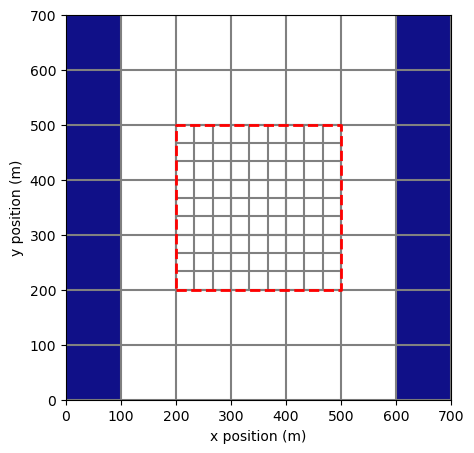

In [6]:
gwf_outer = sim.get_model(gwfname_outer) ; gwf_inner = sim.get_model(gwfname_inner)
fig = plt.figure(figsize=(5, 5)) ; fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0) ; pmv_inner = flopy.plot.PlotMapView(model=gwf_inner, ax=ax, layer=0)
pmv.plot_grid() ; pmv_inner.plot_grid() ; pmv.plot_bc(name="CHD-LEFT", alpha=0.75) ; pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
ax.plot([200, 500, 500, 200, 200], [200, 200, 500, 500, 200], "r--", linewidth=2.0)
ax.set_xlabel("x position (m)") ; ax.set_ylabel("y position (m)") ; plt.show()

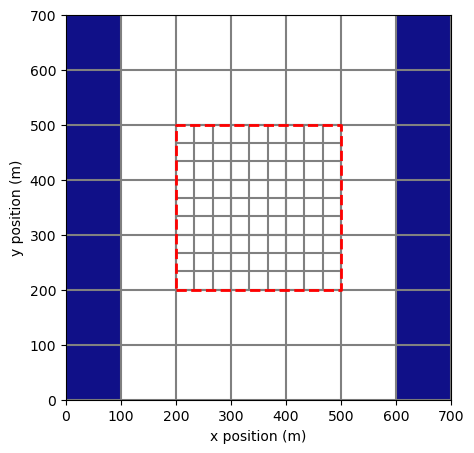

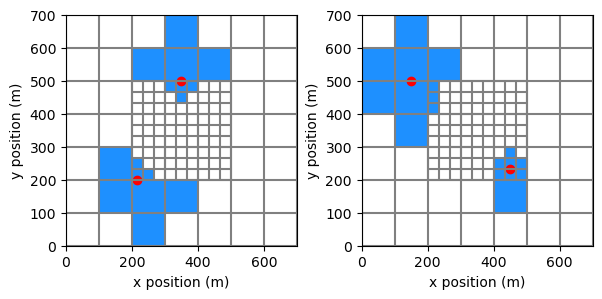

In [7]:
gwf_outer = sim.get_model(gwfname_outer) ; gwf_inner = sim.get_model(gwfname_inner)
fig = plt.figure(figsize=(5, 5)) ; fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0) ; pmv_inner = flopy.plot.PlotMapView(model=gwf_inner, ax=ax, layer=0)
pmv.plot_grid() ; pmv_inner.plot_grid() ; pmv.plot_bc(name="CHD-LEFT", alpha=0.75) ; pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
ax.plot([200, 500, 500, 200, 200], [200, 200, 500, 500, 200], "r--", linewidth=2.0)
ax.set_xlabel("x position (m)") ; ax.set_ylabel("y position (m)") ; plt.show()

gwf_outer = sim.get_model(gwfname_outer) ; gwf_inner = sim.get_model(gwfname_inner) ; fig = plt.figure(figsize=(7, 3)) ; fig.tight_layout()

ax = fig.add_subplot(1, 2, 1, aspect="equal")     ; pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
pmv_inner = flopy.plot.PlotMapView(model=gwf_inner, ax=ax, layer=0, extent=pmv.extent) ; pmv.plot_grid(); pmv_inner.plot_grid()

stencil = np.zeros(pmv.mg.shape, dtype=int) ; stencil_inner = np.zeros(pmv_inner.mg.shape, dtype=int)

stencil[0, 0, 3] = 1       ; stencil[0, 1, 2] = 1       ; stencil[0, 1, 3] = 1       ; stencil[0, 1, 4] = 1  
stencil_inner[0, 0, 3] = 1 ; stencil_inner[0, 0, 4] = 1 ; stencil_inner[0, 0, 5] = 1 ; stencil_inner[0, 1, 4] = 1
stencil[0, 4, 1] = 1       ; stencil[0, 5, 1] = 1       ; stencil[0, 5, 2] = 1       ; stencil[0, 5, 3] = 1   ; stencil[0, 6, 2] = 1
stencil_inner[0, 7, 0] = 1 ; stencil_inner[0, 8, 0] = 1 ; stencil_inner[0, 8, 1] = 1

x = [350.0, 216.666] ; y = [500.0, 200.0]

stencil = np.ma.masked_equal(stencil, 0)  ; stencil_inner = np.ma.masked_equal(stencil_inner, 0)
cmap = ListedColormap(["dodgerblue"]) 
pmv.plot_array(stencil, cmap=cmap) ; pmv_inner.plot_array(stencil_inner, cmap=cmap) ; plt.scatter(x, y, facecolors="r")

ax.set_xlabel("x position (m)") ; ax.set_ylabel("y position (m)")


ax = fig.add_subplot(1, 2, 2, aspect="equal")  # right plot, with stencils '1 connection away from the interface'
pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
pmv_inner = flopy.plot.PlotMapView(model=gwf_inner, ax=ax, layer=0, extent=pmv.extent) ; pmv.plot_grid() ; pmv_inner.plot_grid()

stencil = np.zeros(pmv.mg.shape, dtype=int)  ; stencil_inner = np.zeros(pmv_inner.mg.shape, dtype=int)

stencil[0, 0, 1]=1; stencil[0, 1, 1]=1; stencil[0, 1, 2]=1; stencil[0, 1, 0]=1; stencil[0, 2, 1]=1; stencil[0, 2, 0]=1; stencil[0, 3, 1]=1
stencil_inner[0, 0, 0] = 1; stencil_inner[0, 1, 0] = 1; stencil_inner[0, 2, 0] = 1;

stencil_inner[0, 6, 7] = 1; stencil_inner[0, 7, 6] = 1; stencil_inner[0, 7, 7] = 1; stencil_inner[0, 7, 8] = 1;
stencil_inner[0, 8, 6] = 1; stencil_inner[0, 8, 7] = 1; stencil_inner[0, 8, 8] = 1; stencil[0, 5, 4] = 1;

x = [150.0, 450.0];         y = [500.0, 233.333]

stencil = np.ma.masked_equal(stencil, 0) ; stencil_inner = np.ma.masked_equal(stencil_inner, 0)
cmap = ListedColormap(["dodgerblue"]) 
pmv.plot_array(stencil, cmap=cmap) ;  pmv_inner.plot_array(stencil_inner, cmap=cmap); plt.scatter(x, y, facecolors="r")

ax.set_xlabel("x position (m)") ; ax.set_ylabel("y position (m)") ; plt.show()


### Running the example

Define and invoke a function to run the example scenario, then plot results.

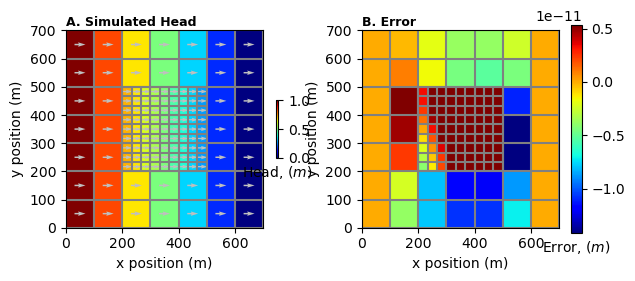

In [8]:
gwf_outer = sim.get_model(gwfname_outer)
gwf_inner = sim.get_model(gwfname_inner)

fig = plt.figure(figsize=(7, 3))
fig.tight_layout()

head = gwf_outer.output.head().get_data()[0]
head_inner = gwf_inner.output.head().get_data()[0]
head[head == 1e30] = np.nan
head_inner[head_inner == 1e30] = np.nan

qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(gwf_outer.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],gwf_outer)
(qx_inner, qy_inner, qz_inner) = (flopy.utils.postprocessing.get_specific_discharge(gwf_inner.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],gwf_inner))

ax = fig.add_subplot(1, 2, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
pmv_inner = flopy.plot.PlotMapView(model=gwf_inner, ax=ax, layer=0, extent=pmv.extent)
cb = pmv.plot_array(head, cmap="jet", vmin=0.0, vmax=1.0)
cb = pmv_inner.plot_array(head_inner, cmap="jet", vmin=0.0, vmax=1.0)
pmv.plot_grid()
pmv_inner.plot_grid()
pmv.plot_vector(qx, qy, normalize=False, color="0.75")
pmv_inner.plot_vector(qx_inner, qy_inner, normalize=False, color="0.75")
cbar = plt.colorbar(cb, shrink=0.25)
cbar.ax.set_xlabel(r"Head, ($m$)")
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
styles.heading(ax, letter="A", heading="Simulated Head")

ax = fig.add_subplot(1, 2, 2, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwf_outer, ax=ax, layer=0)
pmv_inner = flopy.plot.PlotMapView(model=gwf_inner, ax=ax, layer=0, extent=pmv.extent)
pmv.plot_grid()
pmv_inner.plot_grid()
x = np.array(gwf_outer.modelgrid.xcellcenters) - 50.0
x_inner = np.array(gwf_inner.modelgrid.xcellcenters) - 50.0
slp = (h_left - h_right) / (50.0 - 650.0)
head_exact = slp * x + h_left
head_exact_inner = slp * x_inner + h_left
err = head - head_exact
err_inner = head_inner - head_exact_inner
vmin = min(np.nanmin(err), np.nanmin(err_inner))
vmax = min(np.nanmax(err), np.nanmax(err_inner))
cb = pmv.plot_array(err, cmap="jet", vmin=vmin, vmax=vmax)
cb = pmv_inner.plot_array(err_inner, cmap="jet", vmin=vmin, vmax=vmax)

cbar = plt.colorbar(cb, shrink=.9)
cbar.ax.set_xlabel(r"Error, ($m$)")
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
styles.heading(ax, letter="B", heading="Error") ; plt.show()
